In [1]:
# pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


### Import and add Inputs

In [1]:
import tweepy
import csv
import pandas as pd
import json
import string
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import time
import seaborn as sns

####input your credentials here
from config import consumer_key
from config import consumer_secret
from config import access_token
from config import access_token_secret

consumer_key = consumer_key
consumer_secret = consumer_secret
access_token = access_token
access_token_secret = access_token_secret

##OAuth Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)


In [2]:
#tqdm for loops
from tqdm.notebook import tqdm

In [3]:
#We can not pass the parameters directly into the method. Instead we pass the parameters into the Cursor constructor method:
curse = tweepy.Cursor(api.search,q="#recycle",count=10, lang="en", since="2020-05-08", wait_on_rate_limit=False).items()

In [127]:
#test
curse.next()

Status(_api=<tweepy.api.API object at 0x1a298bd7d0>, _json={'created_at': 'Sat May 16 05:04:57 +0000 2020', 'id': 1261523008989966336, 'id_str': '1261523008989966336', 'text': '99% High Quality Clean Water Recovery &amp; Recycling with Lowest TDS and Minimal Electric Energy Demand at Usha Cotton… https://t.co/VgHyo4FOjY', 'truncated': True, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/VgHyo4FOjY', 'expanded_url': 'https://twitter.com/i/web/status/1261523008989966336', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [121, 144]}]}, 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'}, 'source': '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 1946322121, 'id_str': '1946322121', 'name': 'Spray Engineering', 'screen_name

In [89]:
# Open/Create a file to append data

hashtags = ["#airpollution","#AirPollution","#airpollutionmask","#environment" ,
           "#climate", "#climatechange","#climatechangeisreal", "#earth", "#theearth", "#theenviroment",
            "#recycle", "#reduce", "#reuse", "#savetheearth", "#sealevels",
            "#globalwarming", "#pollution", "#waterpollution",
            "#savetheplanet", "#theplanet", "#planet", "#fortheenvironment",
            "#noplanetb", "#earthday", "#earthdayeveryday"]
            
locationsList = []
tweetTextList = []

In [114]:
for hshtg in tqdm(hashtags[23:]):
    print("query for hashtag " + hshtg + "...")
    for tweet in tweepy.Cursor(api.search,q=hshtg, count=400, lang="en", since="2020-05-08", wait_on_rate_limit=True).items(1000):
        location = tweet._json["user"]["location"]
        text = tweet._json["text"]
        locationsList.append(location)
        tweetTextList.append(text)

query for hashtag #earthday...
query for hashtag #earthdayeveryday...



In [115]:
print(len(tweetTextList), len(locationsList))

16425 16425


In [116]:
df = pd.DataFrame({'location': locationsList, 'text': tweetTextList}).drop_duplicates()
df.head()

,location,text
0,"New Delhi, India",Let's segregate our waste with @_WeMeanToClean...
1,"New Delhi, Delhi",Let's segregate our waste with @_WeMeanToClean...
2,,#airpollution #california Federal judge orders...
3,USA,"Kudos to @SadiqKhan, Mayor of #London for his ..."
4,India,"RT @_WeMeanToClean: #DELHI, LET'S SEGREGATE OU..."


In [130]:
## save results by pickle
df.to_pickle('results_400.pkl')

### Create a Data Frame 

In [4]:
df = pd.read_pickle('results_400.pkl')

In [22]:
printable = set(string.printable)
state_codes = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL",
                "IN","IA","KS","KY","LA","ME","MD","MA","MI","MN","MS","MO","MT"
                "NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA","RI",
                "SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]
Get_n_hashtags=lambda n: " OR ".join(hashtags[:n])


In [23]:
#test
x = 'Ithaca, NY, USA, Planet Earth'
items = x.split(',')
items = [x.strip() for x in items]
items

['Ithaca', 'NY', 'USA', 'Planet Earth']

In [24]:
#Create a function that searches for state information
def found_states(x):
    items = x.split(',')
    items = [x.strip() for x in items]
    return any([y in items for y in state_codes])

In [25]:
df = df[df['location'].apply(found_states)].copy()

In [26]:
#what does the dataframe information look like
df.shape

(1154, 3)

In [27]:
df['state'] = df['location'].str.extract('([A-Z]{2})')

<function matplotlib.pyplot.show(*args, **kw)>

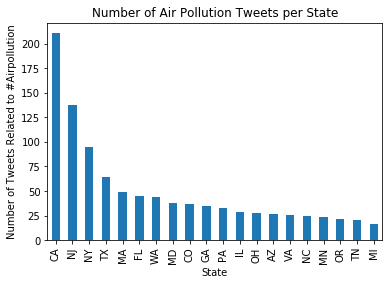

In [28]:
#Create a plot that shows Number of Tweets per State
df['state'].value_counts().head(20).plot(kind='bar')
plt.xlabel('State')
plt.ylabel('Number of Tweets Related to #Airpollution');
plt.title('Number of Air Pollution Tweets per State')
plt.savefig('Number of Tweets Per State.png')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

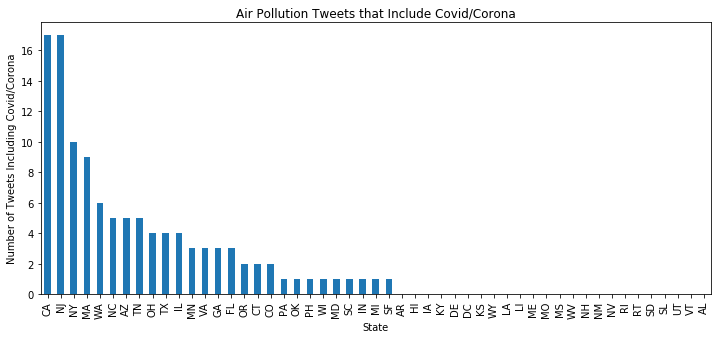

In [29]:
#Create a plot that shows Number of Tweets per State for Covid/Corona
df.groupby('state')['text'].apply(lambda x: x.str.lower().str.contains('covid|corona').sum()).sort_values(ascending=False).plot(kind='bar', figsize=(12,5))
plt.xlabel('State')
plt.ylabel('Number of Tweets Including Covid/Corona');
plt.title('Air Pollution Tweets that Include Covid/Corona')
plt.savefig('Covid_Corona.png')
plt.show

In [30]:
#Create a function to clean the text to use in a word cloud
def clean_text(text):
    filteredText = text.translate(str.maketrans('', '', string.punctuation))
    filteredText = ''.join(filter(lambda x: x in printable, filteredText))
    filteredText = " ".join([term for term in filteredText.split(" ") if "http" not in term])
    return filteredText

In [31]:
df['text'] = df['text'].apply(clean_text)

In [35]:
# Clean the Stopwords more
STOPWORDS.add('rt')
STOPWORDS.add('thi')
STOPWORDS.add('amp')
STOPWORDS.add('ha')
STOPWORDS.add('will')
STOPWORDS.add('http')
STOPWORDS.add('@')
STOPWORDS.add('amp')

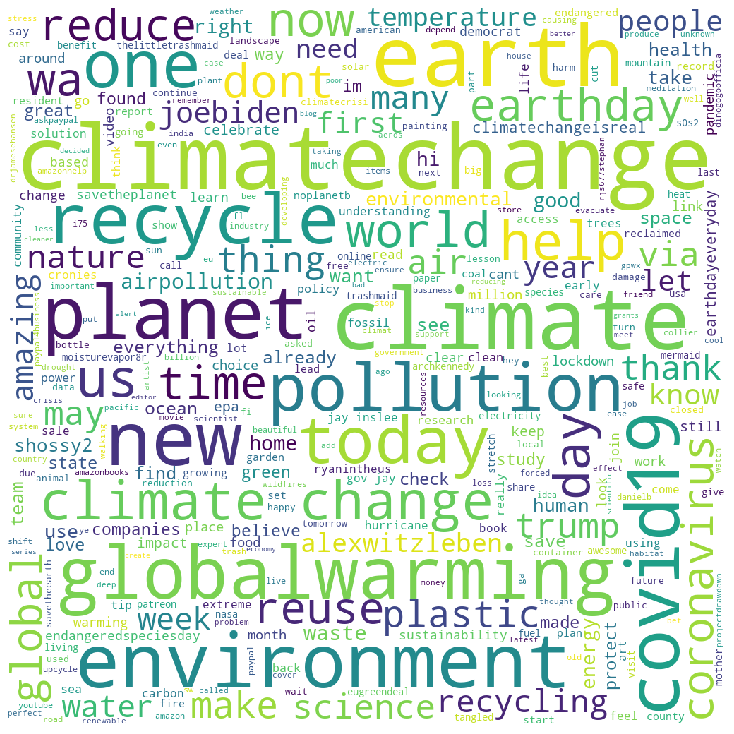

In [36]:
#Plot a Wordcloud
wordcloud = WordCloud(width = 1020, height = 1020,
                background_color ='white',
                max_words=350,
                collocation_threshold = 200,
                stopwords = STOPWORDS).generate(' '.join(df['text'].str.lower().tolist()))

# plot the WordCloud image
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('World_Cloud.png')
plt.show()

In [37]:
from collections import Counter

In [38]:
#Create a Data Frame for Most Common Words used
def most_common(rows):
    txt = ' '.join(rows['text'].str.lower().tolist())
    words = txt.split()
    words = [x for x in words if x not in STOPWORDS]
    words = [x for x in words if len(x) >= 3]
    cnt = Counter(words)
    return ','.join([x[0] for x in cnt.most_common(2)])

In [39]:
Common_words_df = df.groupby('state').apply(most_common).to_frame('Most Common Words').reset_index()
Common_words_df

,state,Most Common Words
0,AL,"noplanetb,squirrelfromms"
1,AR,"hazards,using"
2,AZ,"earth,nature"
3,CA,"climate,environment"
4,CO,"climate,job"
5,CT,"wetlands,online"
6,DC,"cprblog,join"
7,DE,"climate,news"
8,FL,"earth,new"
9,GA,"still,amazing"


In [40]:
Common_words_df.to_csv('Common_words_df')

In [41]:
#Create a top 10 List
def top_10(rows):
    txt = ' '.join(rows['text'].str.lower().tolist())
    words = txt.split()
    words = [x for x in words if x not in STOPWORDS]
    words = [x for x in words if len(x) >= 3]
    cnt = Counter(words)
    top_10 = cnt.most_common(10)
    return pd.Series([x[1] for x in top_10], index=[x[0] for x in top_10])

In [42]:
state_cnt = df.groupby('state').apply(top_10).unstack().fillna(0)

<function matplotlib.pyplot.show(*args, **kw)>

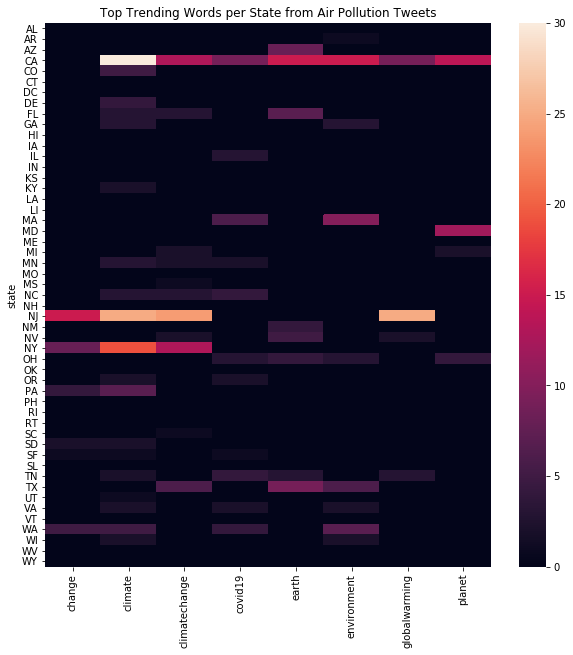

In [43]:
#Plot a Top 10 list
mat = state_cnt.loc[:,state_cnt.sum().sort_values() > 30]
plt.figure(figsize=(10,10))
sns.heatmap(mat)
plt.title('Top Trending Words per State from Air Pollution Tweets')
plt.savefig('Top_Trending_Words.png')
plt.show

In [190]:
df

,location,text,state
100,"St Louis, MO",RT SeanatGreenwire EPA is near a deal in a lon...,MO
124,"Minneapolis, MN",Its CleanAirMonth Airpollutionspecifically nit...,MN
131,"Boston, MA",RT Blondie2wild nichegamer elonmusk Quantitati...,MA
147,"San Diego, CA",This study adds important findings to the grow...,CA
149,"703 7th Ave, Huntington, WV",RT LungAssociation So glad were able to assist...,WV
...,...,...,...
16374,"Dallas, TX",RT GreenDallas From collection to consumption ...,TX
16385,"Brooklyn, NY",RT ANoelleJay I think this is the perfect Eart...,NY
16392,"Dallas, TX",From collection to consumption DWU cares for 4...,TX
16395,"Hartford, CT",The Great Backyard Pursuit starts tomorrow Vis...,CT
